In [1]:
import tensorflow as tf
from datetime import timedelta
import numpy as np
tf.__version__

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


'2.5.0-rc1'

## Preparing X, Y

In [3]:
print("Enter timestep : ",end=' ')
timesteps = int(input())
print(timesteps)

Enter timestep :  2


In [5]:
import pandas as pd
from collections import defaultdict

provinces = ['Bangkok','Chanthaburi','Chiang Mai','Kanchanaburi','Songkhla']
path = './data/Train/fire_integrated/'
data = {}

X = defaultdict(lambda: list())
Y = defaultdict(lambda: list())

hour_step = timedelta(hours=timesteps-1)

predict_at = pd.date_range(start="2016-03-04 00:00:00", end="2019-03-17 23:00:00", freq='6H')

for province in provinces:
    df = pd.read_csv(path+f'{province}_fire_integrated.csv', index_col=0, parse_dates=True)
    data[province] = df

    df = df.fillna(method='ffill')  # Quick fix : frp has some Null

    for base in predict_at:

        if base-hour_step not in df.index : continue
        x = df.loc[base-hour_step: base].drop(['PM2.5'], axis=1)

        till = base+timedelta(hours=72)
        if till not in df.index: break
        y = df.loc[base+timedelta(hours=1): till, ['PM2.5']]

        X[province].append(x)
        Y[province].append(y)


In [6]:
from sklearn.preprocessing import MinMaxScaler

x_scalers, y_scalers = {}, {}

X_scaled = defaultdict(lambda: list())
Y_scaled = defaultdict(lambda: list())

for province in provinces:
    x = data[province].drop(['PM2.5'], axis=1)
    y = data[province][['PM2.5']]

    x_scaler = MinMaxScaler().fit(x)
    y_scaler = MinMaxScaler().fit(y)

    for e in X[province]:
        X_scaled[province].append(x_scaler.transform(e))
        x_scalers[province] = x_scaler
    for e in Y[province]:
        Y_scaled[province].append(y_scaler.transform(e))
        y_scalers[province] = y_scaler


In [7]:
X['Bangkok'][0]

,Temp(C),WindDir,Wind Speed(km/h),Cambodia_frp,Myanmar_frp,Thailand_frp,Lao_PDR_frp
2016-03-03 23:00:00,27.3,70.0,15.0,1.574234,1.238528,4.12,1.274845
2016-03-04 00:00:00,27.3,70.0,15.0,1.574234,1.238528,4.12,1.274845


In [8]:
Y['Bangkok'][0]

,PM2.5
2016-03-04 01:00:00,43.1
2016-03-04 02:00:00,44.8
2016-03-04 03:00:00,37.5
2016-03-04 04:00:00,39.6
2016-03-04 05:00:00,46.0
...,...
2016-03-06 20:00:00,26.0
2016-03-06 21:00:00,32.4
2016-03-06 22:00:00,32.8
2016-03-06 23:00:00,24.8


## Reshaping input

In [9]:
bkk_x = np.array(X_scaled['Bangkok'])
bkk_y = np.array(Y_scaled['Bangkok'])
print(f'X : {bkk_x.shape}')
print(f'Y : {bkk_y.shape}')

X : (4424, 2, 7)
Y : (4424, 72, 1)


In [10]:
np.isnan(bkk_x).any()

False

In [11]:
n_features = len(data[province].columns)-1
x_train = bkk_x.reshape((bkk_x.shape[0], timesteps, n_features))
y_train = bkk_y.reshape((bkk_y.shape[0], 72))

In [12]:
print(f'x : {x_train.shape}')
print(f'y : {y_train.shape}')

x : (4424, 2, 7)
y : (4424, 72)


## Building Model

In [13]:
print(f"timesteps : {timesteps}")

timesteps : 2


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf

# define model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(timesteps, n_features)),
    Dense(72, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

In [70]:
history = model.fit(x_train, y_train, epochs=10, batch_size=100)

Epoch 1/10
45/45 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 2/10
45/45 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 3/10
45/45 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 4/10
45/45 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 5/10
45/45 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 6/10
45/45 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 7/10
45/45 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 8/10
45/45 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 9/10
45/45 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 10/10
45/45 [==============================] - 0s 3ms/step - loss: 0.0092


In [71]:
model.evaluate(x_train, y_train)

139/139 [==============================] - 0s 1ms/step - loss: 0.0094


0.009361001662909985

In [72]:
from sklearn.metrics import mean_squared_error as mse
pred = model(x_train)
rmse = []
for i in range(len(pred)):
    p = y_scalers['Bangkok'].inverse_transform(pred[i].numpy().reshape((-1,1)))
    y_t = y_scalers['Bangkok'].inverse_transform(y_train[i].reshape((-1,1)))
    rmse.append(np.sqrt(mse(p, y_t)))
np.mean(rmse)

9.433256245135501

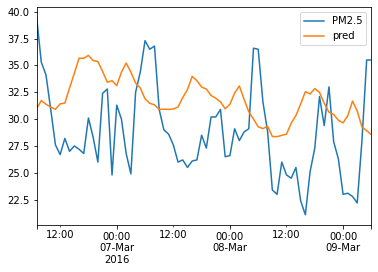

In [81]:
i = 9
h = y_scalers['Bangkok'].inverse_transform(pred[i].numpy().reshape((-1,1)))
k = Y['Bangkok'][i]
k['pred'] = h
k.plot();